# Training


This notebook shows the overall training process of the 3 approaches mentioned in the paper:

- Disease detection
- Symptom identification
- Combined task

We describe the key library imports, outline the modeling process as defined in the paper, and discuss the training loop implemented for each task.

In [1]:
#  Hiding some imports for brevity
import json
import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles
from tqdm import tqdm
import random
import numpy

plt.style.use(Styles.ML.value)

# Introduction

To train the models, we will be using the [PyTorch](10.48550/arXiv.1912.01703) framework and its broader ecosystem. PyTorch provides a flexible and modular API for defining neural network architectures, enabling us to construct custom convolutional networks, configure pretrained backbones, and experiment with alternative model designs as needed.

In [2]:
import torch

## Training imports

We will be using Cross Entropy and Mean Squared Error as a loss function when training our models, conceptually this is what tells the model how wrong its predictions are. Cross Entropy loss is a loss function for multi-class classification models and Mean Squared Error for binary classification models.


For a single sample with true label $y$ and predicted class $\hat{y}$:
$$
\mathcal{L}_{\text{CE}}(y, \hat{y}) = - \sum_{c=1}^{C} y_c \log(\hat{y}_c)
$$

Where:

- $C$ is the number of classes


$$
\mathcal{L}_{\text{MSE}}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$


In [3]:
from iragca.ml import RunLogger
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import SGD

`RunLogger` is a lightweight logger for logging training runs.  

## Evaluation metrics

For computing evaluation metrics, we rely on the [scikit-learn](https://scikit-learn.org/stable/) Python library, which provides standardized implementations of accuracy, F1 score, and other commonly used performance measures [@Pedregosa_Scikit-learn_Machine_Learning_2011].

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In these metrics, true positives (TP) refer to samples that are correctly classified as belonging to the positive class, true negatives (TN) denote samples correctly classified as belonging to the negative class, false positives (FP) represent negative samples that are incorrectly classified as positive, and false negatives (FN) indicate positive samples that are incorrectly classified as negative. These quantities form the basis for computing accuracy, precision, recall, and the F1-score.

In [4]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

## Load and Preprocess

We load the data and perform image resizing as the preprocessing technique. The image sizes will a square 32x32 pixel image, small enough so that training is fast while some information. We also turn the images into tensors so that PyTorch can easily parse the data.

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from lib.config import Directories
from lib.data import ( 
    MegaPlantDataset, 
    UnhealthyMegaPlantDataset, 
    CombinedMegaPlantDataset 
)

In [6]:
IMAGE_SIZE = (32, 32)

We load the data from the `MEGAPLANT_DIR` where the dataset is stored then apply the preprocessing pipeline.

In [ ]:
transform_pipeline = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

MEGAPLANT_DIR = Directories.EXTERNAL_DATA_DIR.value / "huggingface" / "leaves"

megaplant = MegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=transform_pipeline
    )

unhealthy_megaplant = UnhealthyMegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=transform_pipeline
    )

combined_megaplant = CombinedMegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=transform_pipeline
    )

## Building SimpleCNN

![simplecnn](/docs/images/figure6/simplecnn.png)

We specify the layer dimensions, the convolutions, input and output shapes of the images after each convolution or pooling. We use ReLU as our activation function [@10.48550/arXiv.1803.08375].

| Layer | Type      | Kernel | Padding | Stride | Input Shape          | Output Shape   | 
| ----- | --------- | ------ | ------- | ------ | -------------------- | -------------- | 
| 1     | Conv2d    | 3×3    | 1       | 1      | ` 3 × 32 × 32`       | `16 × 33 × 33` |
| 1     | ReLU      | —      | —       | —      | `16 × 33 × 33`       | `16 × 33 × 33` |
| 2     | MaxPool2d | 2×2    | 0       | 2      | `16 × 33 × 33`       | `16 × 16 × 16` |
| 3     | Conv2d    | 3×3    | 1       | 1      | `16 × 16 × 16`       | `32 × 17 × 17` |
| 3     | ReLU      | —      | —       | —      | `32 × 17 × 17`       | `32 × 17 × 17` |
| 4     | MaxPool2d | 2×2    | 0       | 2      | `32 × 17 × 17`       | `32 ×  8 ×  8` |
| 5     | Flatten   | —      | —       | —      | `32 ×  8 ×  8`       | `2048`         |
| 6     | Linear    | —      | —       | —      | `2048`               | `128`          | 
| 6     | ReLU      | —      | —       | —      | `128`                | `128`          | 
| 7     | Linear    | —      | —       | —      | `128`                | `output_dim`   | 

:::{tip}
The shapes are formatted as `(channel x width x height)`, i.e The output of layer 4 has a shape of 32 channels/feature maps, and a square 8x8 image. Imagine an 8x8 image with 32 stacked layers instead of 3 for {abbr}`RGB (Red, Green, Blue)`!
:::

Here we build the model as a `SimpleCNN` class where its input are `channels` and `output_dim`. Channels are the image channels of our images, in this case is '{abbr}`RGB (Red, Green, Blue)`' so we have 3. Output dim is simply the amount of classes that we want to have, and this is dependent on the current task whether binary or multi-class classification.

In [8]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, channels: int, output_dim: int = 1):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        return self.network(x)

### Image sizes

We verify the image sizes after each convolution and pooling layer. For an input image of size $ W \times W $, the output spatial dimension after a convolution is:
$$
W_{\text{out}} = \left\lfloor\frac{W_{\text{in}} + 2P - K}{S}\right\rfloor + 1
$$
Where:

| Symbol             | Meaning                           |
| ------------------ | --------------------------------- |
| $W_{\text{in}}$  | Input width/height (square image) |
| $W_{\text{out}}$ | Output width/height               |
| $K$              | Kernel size                       |
| $P$              | Padding                           |
| $S$              | Stride                            |




In [9]:
def calc_out(image_width, filter_size, stride: int = 1, padding: int = 0):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    image_size = ((image_width - filter_size + 2 * padding) // stride) + 1
    return image_size

conv1 = calc_out(32, 2, 1, 1)
print("Conv2d:", conv1)
conv2 = calc_out(conv1, 2, 2, 0)
print("MaxPool2Dconv2:", conv2)
conv3 = calc_out(conv2, 2, 1, 1)
print("Conv2d:", conv3)
conv4 = calc_out(conv3, 2, 2, 0)
print("MaxPool2Dconv4:", conv4)

Conv2d: 33
MaxPool2Dconv2: 16
Conv2d: 17
MaxPool2Dconv4: 8


At the final pooling layer we get an image size of 8x8 pixels.

# Training

Our goal is to output 3 models suited for the tasks Disease Detection, Symptom Identification and a combination of the two.

We then specify our constants / hyperparameters for the training process:

In [10]:
BATCH_SIZE = 32                 # Batch size for training
EPOCHS = 50                     # Number of epochs to train the model
LEARNING_RATE = 0.01            # Learning rate for the optimizer
OPTIMIZER = SGD                 # Optimizer to use for training
SPLIT_RATIO = [0.7, 0.2, 0.1]   # Train, validation, test split ratios
THRESHOLD = 0.5                 # Threshold for classification decisions 
RANDOM_STATE = 42               # Random state for reproducibility

We define some helper functions to help us downstream when we are finished training each model.

In [11]:
def plot_results(logger: RunLogger) -> None:
    """Plot training and validation metrics over epochs."""
    fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

    sns.lineplot(x=logger.steps, y=logger.train_loss, label='Train Loss', ax=ax[0])
    sns.lineplot(x=logger.steps, y=logger.val_loss, label='Validation Loss', ax=ax[0])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss over Epochs')

    sns.lineplot(x=logger.steps, y=logger.train_acc, label='Train Accuracy', ax=ax[1])
    sns.lineplot(x=logger.steps, y=logger.val_acc, label='Validation Accuracy', ax=ax[1])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy over Epochs')

    sns.lineplot(x=logger.steps, y=logger.train_f1, label='Train F1 Score', ax=ax[2])
    sns.lineplot(x=logger.steps, y=logger.val_f1, label='Validation F1 Score', ax=ax[2])
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_title('F1 Score over Epochs')

In [12]:
def save_trained_model(model: torch.nn.Module, model_name: str) -> None:
    """Save the trained model's state dictionary."""
    torch.save(model.state_dict(), Directories.MODELS_DIR.value / f"{model_name}.pth")

def save_training_results(logger: RunLogger, model_name: str) -> None:
    """Save the training results to a JSON file."""
    with open(Directories.MODELS_DIR.value / f"{model_name}_train_results.json", "w") as f:
        json.dump(logger.get_logs(), f)

def load_training_results(model_name: str) -> dict:
    """Load training results from a JSON file."""
    with open(Directories.MODELS_DIR.value / f"{model_name}_train_results.json", "r") as f:
        return json.load(f)

We set PyTorch's, NumPy's and Random's random number generator to a specific state `42`.

In [13]:
torch.manual_seed(RANDOM_STATE)
numpy.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

rng = torch.Generator().manual_seed(RANDOM_STATE)

## Disease Detection

In [14]:
train_data, val_data, test_data = random_split(megaplant, SPLIT_RATIO, generator=rng)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

In [ ]:
disease_detection_model = SimpleCNN(channels=3, output_dim=1)
optimizer = OPTIMIZER(disease_detection_model.parameters(), lr=LEARNING_RATE)
criterion = MSELoss()

def train(model, optimizer, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        tqdm=tqdm, 
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        y_trues, y_preds = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_pred = (outputs >= THRESHOLD).long().view(-1)
            y_trues.extend(targets.cpu().numpy())
            y_preds.extend(y_pred.cpu().tolist())

        train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(y_trues, y_preds)
        train_f1_score = f1_score(y_trues, y_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_y_trues, val_y_preds = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets.float())
                val_loss += loss.item()
                val_y_trues.extend(targets.cpu().numpy())
                val_y_preds.extend((outputs >= THRESHOLD).long().cpu().numpy())
            val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(val_y_trues, val_y_preds)
            val_f1_score = f1_score(val_y_trues, val_y_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_acc': train_accuracy,
            'train_f1': train_f1_score,
            'val_loss': val_loss,
            'val_acc': val_accuracy,
            'val_f1': val_f1_score
            }, epoch)

    return logger

disease_detection_logger = train(disease_detection_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # the model weights and training results
# # to the disk
# # ============

# model_name = "disease_detection_model"
# save_trained_model(disease_detection_model, model_name)
# save_training_results(disease_detection_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model weights and training results
# # from the disk
# # ============

# model_name = "disease_detection_model"
# disease_detection_model = SimpleCNN(channels=3, output_dim=1)
# disease_detection_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# disease_detection_logger = RunLogger.from_logs(load_training_results(model_name))

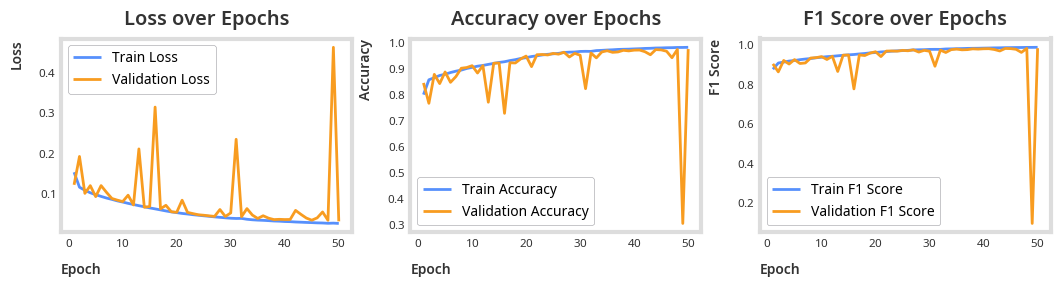

In [16]:
plot_results(disease_detection_logger)

In [17]:
total_params = sum(p.numel() for p in disease_detection_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 267489


### Testing

In [18]:
disease_detection_model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    disease_detection_model.to(device)
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="Testing", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs_batch = disease_detection_model(inputs)
        preds = (outputs_batch >= THRESHOLD).long().view(-1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

Testing: 100%|██████████| 189/189 [01:09<00:00,  2.72batch/s]


In [19]:
f1 = f1_score(all_targets, all_preds, average='weighted')
accuracy = accuracy_score(all_targets, all_preds)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

F1 Score: 0.9807
Accuracy: 0.9807


## Symptom Identification

In [36]:
train_data, val_data, test_data = random_split(unhealthy_megaplant, SPLIT_RATIO, generator=rng)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [ ]:
symptom_identification_model = SimpleCNN(channels=3, output_dim=len(unhealthy_megaplant.SYMPTOM_MAP))
optimizer = OPTIMIZER(symptom_identification_model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

def train(model, optimizer, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=False,
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

symptom_identification_logger = train(symptom_identification_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # the model weights and training results
# # to the disk
# # ============

# model_name = "symptom_identification_model"
# save_trained_model(symptom_identification_model, model_name)
# save_training_results(symptom_identification_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model weights and training results
# # from the disk
# # ============

# model_name = "symptom_identification_model"
# symptom_identification_model = SimpleCNN(channels=3, output_dim=len(unhealthy_megaplant.SYMPTOM_MAP))
# symptom_identification_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# symptom_identification_logger = RunLogger.from_logs(load_training_results(model_name))

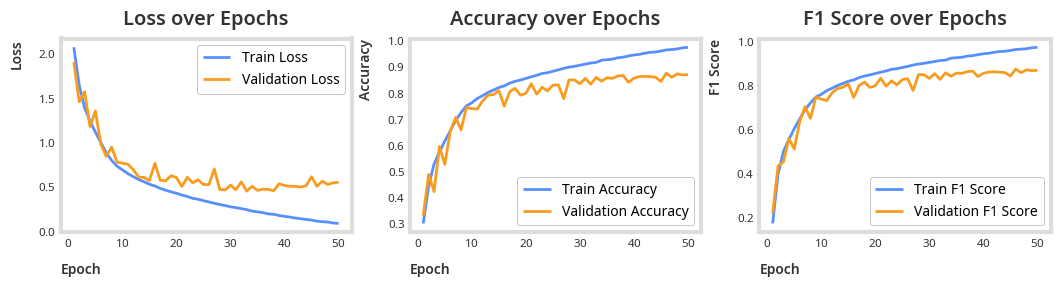

In [22]:
plot_results(symptom_identification_logger)

In [23]:
total_params = sum(p.numel() for p in symptom_identification_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 268908


### Testing

In [37]:
symptom_identification_model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    symptom_identification_model.to(device)
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="Testing", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = symptom_identification_model(inputs)
        test_pred = outputs.argmax(dim=1)
        all_preds.extend(test_pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

Testing: 100%|██████████| 139/139 [01:04<00:00,  2.14batch/s]


In [38]:
print("Accuracy:", accuracy_score(all_targets, all_preds))

Accuracy: 0.9385588434605828


In [25]:
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       649
           1       0.98      0.99      0.99       579
           2       1.00      0.97      0.98       545
           3       0.99      0.95      0.97       286
           4       0.94      0.91      0.92       386
           5       0.97      0.92      0.95       103
           6       1.00      0.75      0.86        40
           7       0.93      0.93      0.93       172
           8       0.95      0.93      0.94       182
           9       0.87      0.84      0.85        63
          10       0.91      0.96      0.93      1300
          11       0.98      0.96      0.97       122

    accuracy                           0.95      4427
   macro avg       0.95      0.92      0.93      4427
weighted avg       0.95      0.95      0.95      4427



## Combined task

In [26]:
train_data, val_data, test_data = random_split(combined_megaplant, SPLIT_RATIO, generator=rng)

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [ ]:
combined_identification_model = SimpleCNN(channels=3, output_dim=len(combined_megaplant.CLASS_MAP))
optimizer = OPTIMIZER(combined_identification_model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

def train(model, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=True, 
        unit="epoch", 
        desc="Epochs",
        position=0
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

combined_identification_logger = train(combined_identification_model, optimizer, criterion, epochs=EPOCHS)

In [ ]:
# # ============
# # Uncomment this cell to save
# # the model weights and training results
# # to the disk
# # ============

# model_name = "combined_identification_model"
# save_trained_model(combined_identification_model, model_name)
# save_training_results(combined_identification_logger, model_name)

In [ ]:
# # ============
# # Uncomment this cell to load
# # the model weights and training results
# # from the disk
# # ============

# model_name = "combined_identification_model"
# combined_identification_model = SimpleCNN(channels=3, output_dim=len(combined_megaplant.CLASS_MAP))
# combined_identification_model.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{model_name}.pth"))
# combined_identification_logger = RunLogger.from_logs(load_training_results(model_name))

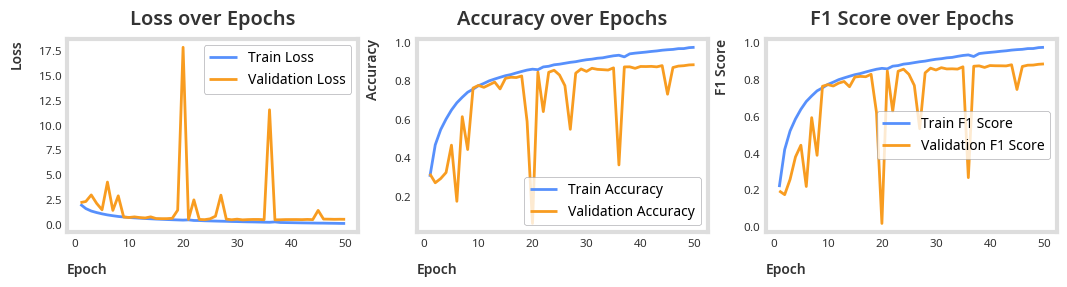

In [28]:
plot_results(combined_identification_logger)

In [29]:
total_params = sum(p.numel() for p in combined_identification_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 269037


### Testing

In [34]:
all_preds, all_targets = [], []

combined_identification_model.eval()
combined_identification_model.to("cuda")
for inputs, targets in tqdm(test_loader, desc="Testing", unit="batch"):
    inputs, targets = inputs.to("cuda"), targets.to("cuda")
    with torch.no_grad():
        outputs = combined_identification_model(inputs)
        test_pred = outputs.argmax(dim=1)
        all_preds.extend(test_pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

Testing: 100%|██████████| 189/189 [01:09<00:00,  2.72batch/s]


In [35]:
print("Accuracy:", accuracy_score(all_targets, all_preds))

Accuracy: 0.9511627906976744


In [31]:
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       670
           1       0.98      0.98      0.98       549
           2       0.97      0.98      0.98       546
           3       0.99      0.96      0.97       296
           4       0.90      0.91      0.90       385
           5       0.90      0.84      0.87        90
           6       0.90      0.93      0.92        41
           7       0.95      0.94      0.95       175
           8       0.96      0.96      0.96       185
           9       0.89      0.84      0.87        81
          10       0.94      0.93      0.93      1323
          11       0.95      0.96      0.95       109
          12       0.97      0.98      0.97      1570

    accuracy                           0.95      6020
   macro avg       0.94      0.93      0.94      6020
weighted avg       0.95      0.95      0.95      6020



In [32]:
labels_for_combined = []
preds_for_combined = []

for label, pred in zip(all_targets, all_preds):
    if label == combined_megaplant.CLASS_MAP['healthy']:
        labels_for_combined.append(0)
        if pred != combined_megaplant.CLASS_MAP['healthy']:
            preds_for_combined.append(1)
        else:
            preds_for_combined.append(0)

    else:
        labels_for_combined.append(1)
        if pred != combined_megaplant.CLASS_MAP['healthy']:
            preds_for_combined.append(1)
        else:
            preds_for_combined.append(0)

accuracy_score(labels_for_combined, preds_for_combined)

0.9863787375415283

In [33]:
f1_score(labels_for_combined, preds_for_combined)

0.9907803013267371

# Results and Discussion

| Task                   | F1 Score | Accuracy | Binary F1 Score | Binary Accuracy |
| ---------------------- | -------- | -------- | --------------- | --------------- |
| Disease Detection      | 0.98     | 98.07%   | 0.98            | 98.07%          |
| Symptom Identification | 0.95     | 93.86%   | -               | -               |
| Combined               | 0.95     | 95.12%   | 0.99            | 98.64%          |

We observe that Symptom Identification and Disease Detection individually perform slightly worse than the combined task. While decentralizing decision-making could be beneficial, particularly if more accurate symptom identification models become available in the future, in this case, using a combined model for inference provides only a marginal improvement.

Overall, they perform almost close to perfect, relative to the best model evaluated by the authors of DiaMOS [@10.48550/arXiv.1905.11946, pg. 6] with an accuracy 86.05% trained for both disease detection and symptom identification. On par with GoogleNET, a network with more than 3 million parameters with an accuracy of 99% trained for the same task [@10.1109/CVPR.2015.7298594; @10.3389/fpls.2016.01419, pg. 7].

# Summary

We introduced necessary library imports, defined loss functions and evaluation metrics, we specified network architecture of and built the SimpleCNN model which we trained to do 3 tasks, disease detection, symptom identification and a combination of the two. We discussed and compared with results and determined that the 3 models performed well.